<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombres:**
- Perez Balcorta, Leonardo Xavier
- Castillejos Jauregui, Claudia Celeste

**Fecha:** 07 de enero del 2023.

**Expediente** :
- 
- 735868
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/Claudia0806/Tarea2_CCCastillejos_LXPerez



# <span style="color:darkblue"> Tarea 2. </span>

Para ejemplo estudiado en esta clase data WWWUsage.csv probar lo siguiente:
1. Encontrar el mejor modelo ARIMA usando los criterios de AIC, BIC y log-verosimilud, justificando la estructura propuesta.
2. Analizar el efecto de normalizar la serie de tiempo, es decir usar MinMaxScaler para normalizar los datos. Posterior a esto, realizar el mismo precedimiento realizado en clase y encontrar el mejor modelo de ARIMA. Justifique todos los análisis realizados, incluyendo los resultados de las gráficas de ACF y PAC.
3. Investigar la implementación y teoría de los modelos SARIMAX. Además de eso, generar un modelo de pronóstico usando SARIMAX, donde todo el procediemiento anteriormente descrito es implementado, para el siguiente conjunto de datos con estacionalidad:
```
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data2 = pd.read_stata(BytesIO(air2))
data2.index = pd.date_range(start=datetime(data2.time[0], 1, 1), periods=len(data2), freq='MS')
```
**Nota**: Pueden basarse en el siguiente enlace para entender el análisis a realizar 
https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

4. Realizar una predicción de 20 unidades de tiempo en el futuro, tanto para el modelo ARIMA como SARIMA y reportar los resulados en una gráfica donde se puedan observar los datos reales y los datos predichos, cómo en la siguiente gráfica:


In [1]:
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from io import BytesIO
import pandas as pd

# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

# plt.rc("figure", figsize=(11,8))
plt.rc("font", size=12)

In [2]:
data = pd.read_csv('WWWusage.csv', names=[ 'values'], header=0)
data.index = data.index.droplevel()
df = data.copy()
data.head()

,values
1,88
2,84
3,85
4,85
5,84


### <span style="color:darkblue"> Alumno #1: Claudia Celeste Castillejos Jáuregui </span>

####  Preparación de datos

In [3]:
# Checamos que la serie de tiempo no tenga ningún dato atípico 
print(f'Número de filas con missing values: {data.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


Fechas train : 1 --- 80  (n=80)
Fechas test  : 81 --- 100  (n=20)


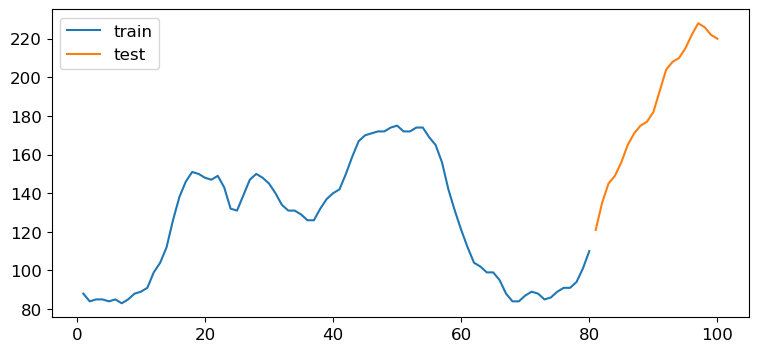

In [4]:
# Separación los datos en train y test.
steps = 20
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Fechas train : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Fechas test  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(9, 4))
data_train['values'].plot(ax=ax, label='train')
data_test['values'].plot(ax=ax, label='test')
ax.legend();


#### Analizar la serie de tiempo

<AxesSubplot:>

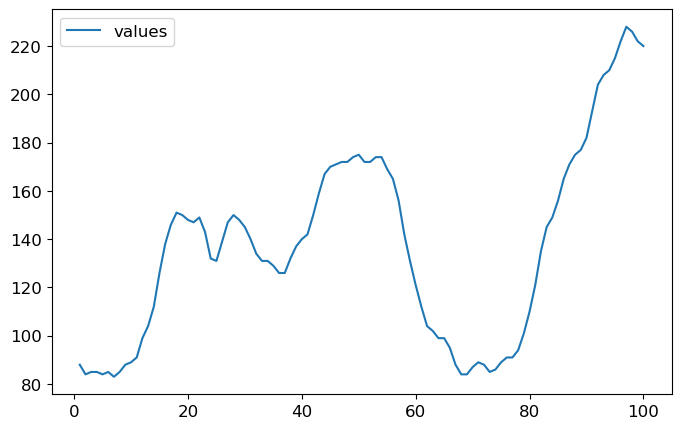

In [5]:
# Mostramos la serie de tiempo
df.plot(figsize=(8,5))

Conclusiones

In [6]:
# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
df_ciclo, df_tend = sm.tsa.filters.hpfilter(df['values'])
df['tend'] = df_tend

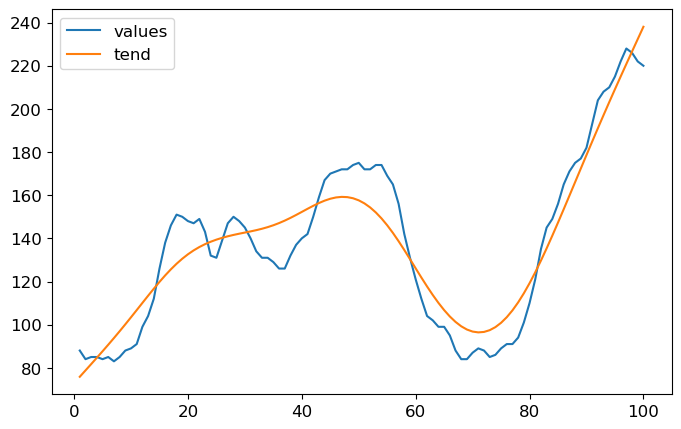

In [7]:
# graficando la serie de tiempo con la tendencia.
df[['values', 'tend']].plot(figsize=(8, 5), fontsize=12);
legend = plt.legend()
legend.prop.set_size(14);

Conclusiones:

#### Modelar la serie de tiempo

In [9]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [10]:
adf_test(data_train)

Results of Dickey-Fuller Test:
Test Statistic                 -2.649346
p-value                         0.083221
#Lags Used                      3.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary


Conclusiones:
No es estacionaria por que no cumple con que el p-value sea menor que 0.05 por lo tanto vamos a probar con diferenciaciones

In [11]:
# Ilustración de la diferenciación en pandas
ilustracion = pd.DataFrame()

ilustracion['real'] = data_train
ilustracion['1d'] = data_train.diff()
ilustracion['p=2'] = data_train.diff(periods=2)
ilustracion['2d'] = data_train.diff().diff()

ilustracion

,real,1d,p=2,2d
1,88,NaN,NaN,NaN
2,84,-4.0,NaN,NaN
3,85,1.0,-3.0,5.0
4,85,0.0,1.0,-1.0
5,84,-1.0,-1.0,-1.0
...,...,...,...,...
76,91,2.0,5.0,-1.0
77,91,0.0,2.0,-2.0
78,94,3.0,3.0,3.0
79,101,7.0,10.0,4.0


In [12]:
diff1_values = data_train.diff().dropna()

print('ADF para derivada primer orden...\n')
adf_test(diff1_values)

diff2_values = data_train.diff().diff().dropna()
print('ADF para derivada segundo orden...\n')
adf_test(diff2_values)

ADF para derivada primer orden...

Results of Dickey-Fuller Test:
Test Statistic                 -2.504537
p-value                         0.114374
#Lags Used                      2.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary
ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                -8.236551e+00
p-value                        5.869012e-13
#Lags Used                     1.000000e+00
Number of Observations Used    7.600000e+01
Critical Value (1%)           -3.519481e+00
Critical Value (5%)           -2.900395e+00
Critical Value (10%)          -2.587498e+00
dtype: float64
Stationary


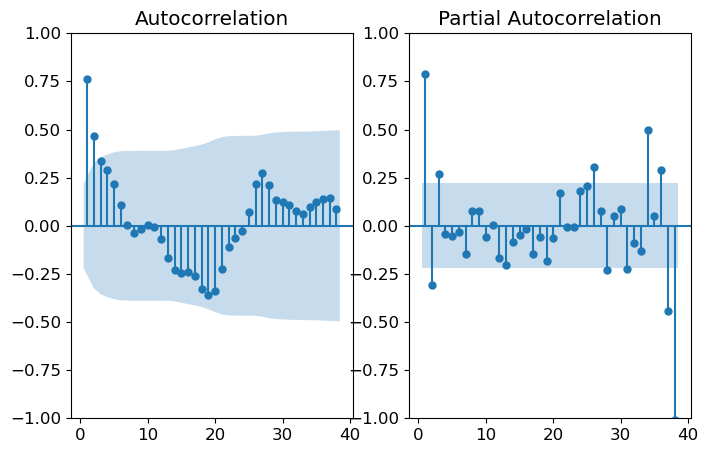

In [13]:
# 1. Graficar ACF y PACF
def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))

    ax1 = f.add_subplot(121)

    plot_acf(data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()

plot_acf_pacf(diff1_values, {'lags':38})

En base a los gráficos anteriores con diferenciación 1, los posibles valores de $p$, $d$ y $q$ son 3,1,2.

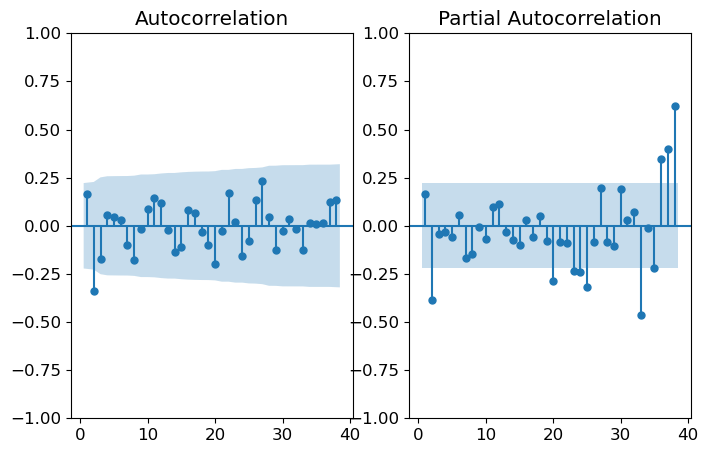

In [14]:
plot_acf_pacf(diff2_values, {'lags':38})

En base a los gráficos anteriores con diferenciación 2, los posibles valores de $p$, $d$ y $q$ son 2,2,2.

#### Modelo 1 ARIMA(3,1,2)

In [19]:
# 1. Modelo de diferencia de primer orden
arima_model1 = ARIMA(data_train, order=(3, 1, 2))
model1 = arima_model1.fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                   80
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -201.589
Date:                Mon, 06 Feb 2023   AIC                            415.178
Time:                        20:52:03   BIC                            429.394
Sample:                             0   HQIC                           420.873
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1445      0.227     -0.636      0.525      -0.590       0.301
ar.L2          0.1469      0.227      0.648      0.517      -0.297       0.591
ar.L3          0.3064      0.189      1.621      0.1

<AxesSubplot:>

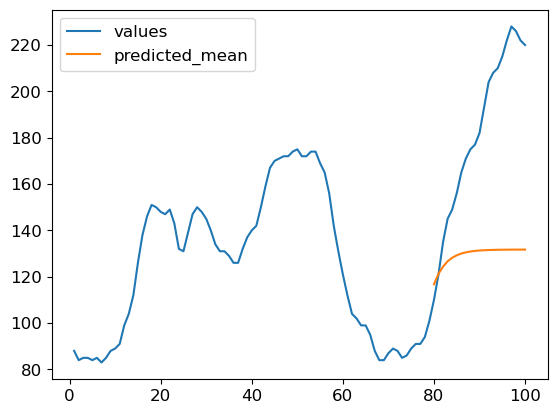

In [20]:
# Predicción
y_h = model1.predict(start=80, end=100, dynamic=False).to_frame()

ax = data.plot()

y_h.plot(ax=ax)

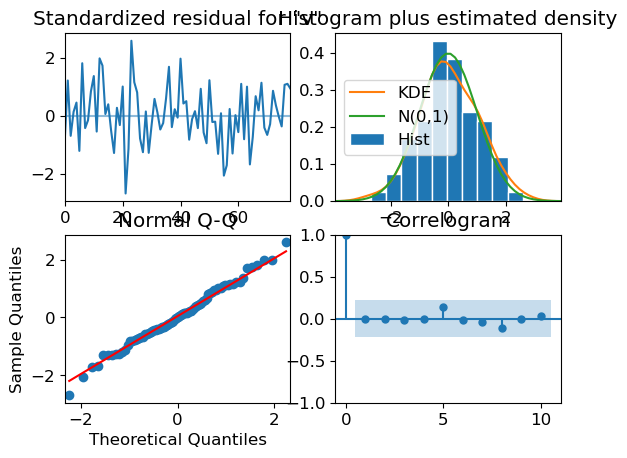

In [17]:
# Gráfico de los diagnósticos para los residuos
model1.plot_diagnostics();

#### Modelo 2 ARIMA(2,2,2)

In [21]:
arima_model2 = ARIMA(data_train, order=(2, 2, 2))
model2 = arima_model2.fit()
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                   80
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -202.613
Date:                Mon, 06 Feb 2023   AIC                            415.225
Time:                        20:54:34   BIC                            427.009
Sample:                             0   HQIC                           419.943
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4506      0.289      1.562      0.118      -0.115       1.016
ar.L2         -0.2584      0.262     -0.985      0.325      -0.772       0.256
ma.L1         -0.2520      0.294     -0.857      0.3

<AxesSubplot:>

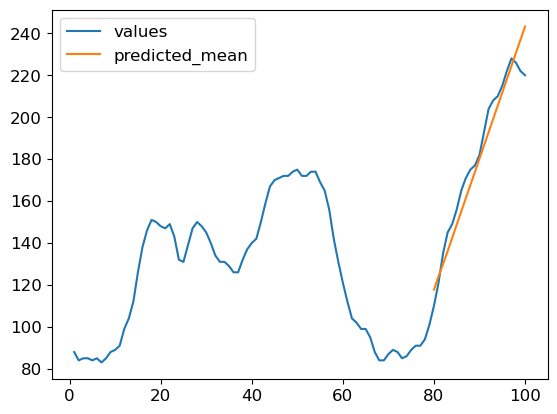

In [22]:
# Cómo realizar predicciones con el modelo ajustado
y_h = model2.predict(start=80, end=100, dynamic=False).to_frame()

ax = data.plot()

y_h.plot(ax=ax)

### <span style="color:darkblue"> Alumno #2 </span>